In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm
import pandas as pd
import uncertainties.unumpy as unp
from scipy.optimize import curve_fit
from statistics import mode
# import ipyparams # only in notebook, not in jupyter lab

In [2]:
save_plot = True # False

# currentNotebook = ipyparams.notebook_name[:len(ipyparams.notebook_name)-6] # get name of currect notebook
# assert currentNotebook != '', "no notebook name, run cell again"

currentNotebook = "total_defl_combined"

plot_dir = 'plots/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(plot_dir))

df_dir = 'data/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(df_dir))

0

# E_i = 1 PeV

In [3]:
df_dict_unsorted = {}
for i, hdf in enumerate(sorted(os.listdir('data/total_defl_combined/'))):
    df = pd.read_hdf('data/total_defl_combined/{}'.format(hdf), key='seed_3')
    df_dict_unsorted['df_%02d' %(i+1)] = df

    
E_f_unsorted = [mode(df_dict_unsorted[df].E_f) for df in df_dict_unsorted]

df_dict = {}
for df in [x for _, x in sorted(zip(E_f_unsorted, df_dict_unsorted.keys()))]:
    df_dict[df] = df_dict_unsorted[df]
print(df_dict.keys())
E_f = sorted(E_f_unsorted)
E_f

dict_keys(['df_10', 'df_09', 'df_04', 'df_08', 'df_03', 'df_07', 'df_02', 'df_06', 'df_01', 'df_05'])


[10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0,
 10000.0,
 50000.0,
 100000.0,
 500000.0]

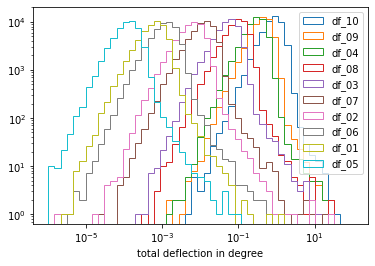

In [4]:
bins = np.logspace(-6, 2, 50)
for d in df_dict:
    df = df_dict[d]
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.legend()

argmax:  24
number events:  50000
Current CL:  0.6844
maxixum:  2.9000000000000004
lower:  2.0
upper:  4.0
max =  2.9000000000000004  -  0.9000000000000004  +  1.0999999999999996


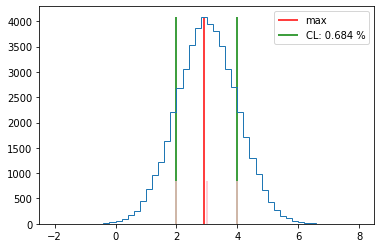

In [5]:
# get 95% smallest interval around the modal 
def get_smallest_interval_around_mode(values, bins, CL=0.68, show=False, plot=False):
    '''Determines smallest interval of x percent located around the modal value.
       Fine binnig results to more precise results.
    
    '''
    binned_counts, bin_edges = np.histogram(values, bins=bins)
    arg_max = np.argmax(binned_counts)
    n_sum = np.sum(binned_counts)
    n_sorted = np.sort(binned_counts)[::-1]
    n_argsort = np.argsort(binned_counts)[::-1]
    c = 0
    for id_argsort,i,counts in zip(range(len(n_argsort)), n_argsort, n_sorted):
        c += counts
        if c/n_sum >= CL:
            c_level = np.round(c/n_sum, 3)
            if i < arg_max: # lower limit
                # print('i < argmax')
                lower = bin_edges[i]
                while i < arg_max:
                    id_argsort += 1
                    i = n_argsort[id_argsort]
                upper = bin_edges[i]
            elif i > arg_max: 
                # print('i > argmax')
                upper = bin_edges[i]
                while i > arg_max:
                    id_argsort -= 1
                    i = n_argsort[id_argsort]
                lower = bin_edges[i]
            else:
                print('ERROR: i == argmax')
            break
    
    maximum = (bin_edges[arg_max] + bin_edges[arg_max + 1])/2
    cl = {
        'maximum': maximum,
        'lower_bound': lower,
        'upper_bound': upper,
        'CL': c_level,
    }        
    if show:
        print('argmax: ', arg_max)
        print('number events: ', np.sum(binned_counts))
        print('Current CL: ', c/n_sum)
        print('maxixum: ', maximum)
        print('lower: ', lower)
        print('upper: ', upper)
        print('max = ', maximum, ' - ', maximum-lower, ' + ',upper-maximum)
    if plot:
        plt.vlines(cl['maximum'], 1, np.max(binned_counts), color='red', label='max')
        plt.vlines(cl['lower_bound'], 1, np.max(binned_counts), color='green')
        plt.vlines(cl['upper_bound'], 1, np.max(binned_counts), color='green', label='CL: {} %'.format(cl['CL']))

    return cl

gaus = np.random.normal(3, size=50000)
bins = np.linspace(-2, 8, 51)
plt.hist(gaus, bins=bins, histtype='step')
si = get_smallest_interval_around_mode(gaus, bins=bins, CL=0.68, show=True, plot=True)

plt.vlines(np.quantile(gaus, 0.155), 0, 850, color='pink')
plt.vlines(np.quantile(gaus, 0.5), 0, 850, color='pink')
plt.vlines(np.quantile(gaus, 0.835), 0, 850, color='pink')
plt.legend()

argmax:  354
number events:  50000
Current CL:  0.95042
maxixum:  0.000690013036756923
lower:  8.668379930019774e-05
upper:  0.0022250887981283695
max =  0.000690013036756923  -  0.0006033292374567253  +  0.0015350757613714465


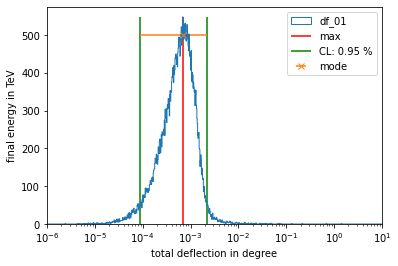

In [6]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in ['df_01']:
    df = df_dict[d]
    # si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.3, show=True, plot=True)
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=True, plot=True)
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode, 500, xerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.xlim(1e-6, 10)
plt.legend()

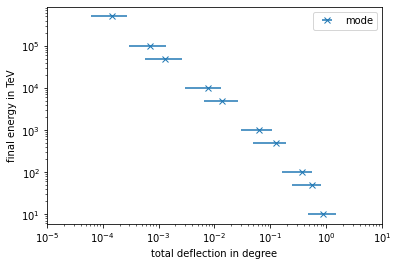

In [7]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in df_dict: # ['df_00']:
    df = df_dict[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.68, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode, E_f, xerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.xlim(1e-5, 10)
plt.legend()

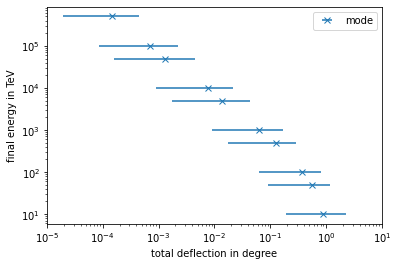

In [8]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in df_dict: # ['df_00']:
    df = df_dict[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode, E_f, xerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.xlim(1e-5, 10)
plt.legend()

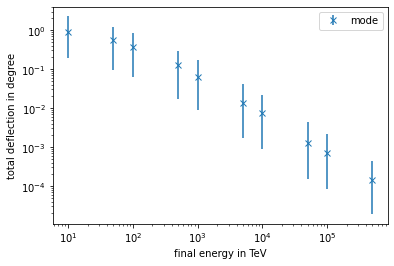

In [9]:
bins = np.logspace(-6, 2, 1000)

deflection_mode = []
deflection_mode_lower = []
deflection_mode_upper = []
for d in df_dict: # ['df_00']:
    df = df_dict[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode.append(si['maximum'])
    deflection_mode_lower.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper.append(si['upper_bound'] - si['maximum'])

plt.errorbar(E_f, deflection_mode, yerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('total deflection in degree')
plt.xlabel('final energy in TeV')
plt.legend()

lin params:  [ 1.17339062 -0.84939739] , errors:  [0.15075888 0.04127486]
lin params cut:  [ 1.57775077 -0.94292727] , errors:  [0.09146055 0.0227301 ]
efit params:  [-2.72885489  0.17183148  3.33401275] , errors:  [1.01269671 0.03910835 1.13466281]


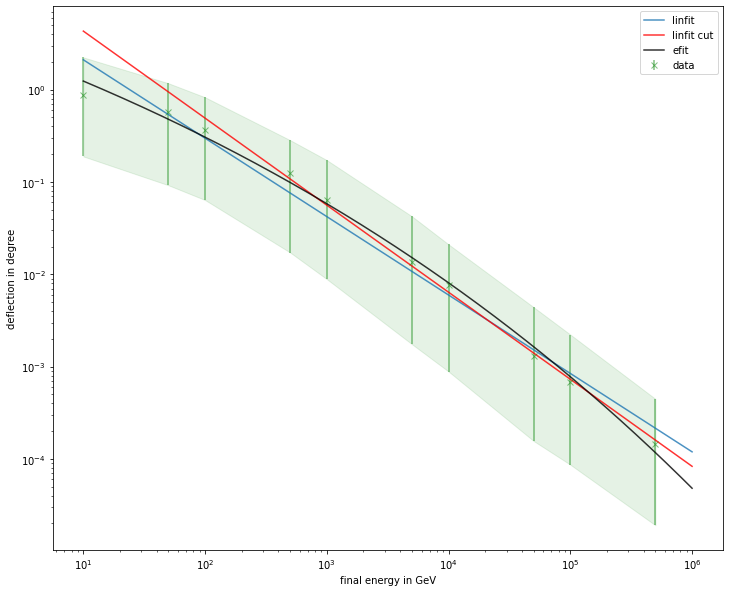

In [10]:
### fit deflection modes 
x = np.logspace(1, 6, 1000)
plt.figure(figsize=(12, 10))

# Power fit
def powerfit(x, a, b):
    return a * np.power(x, b)

params, cov = curve_fit(powerfit, E_f, deflection_mode, p0=(20, -1))
errors = np.sqrt(np.diag(cov))
# print('power params: ', params, ', errors: ', errors)
# plt.plot(x, powerfit(x, *params), alpha=0.8, label='powerfit')



# Lin fit with all energies
def linlaw(x, a, b) :
    return a + x * b

params, cov = curve_fit(linlaw, np.log10(E_f), np.log10(deflection_mode)) 
errors = np.sqrt(np.diag(cov))
print('lin params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), alpha=0.8, label='linfit')

# Lin fit without 10 GeV and 50 GeV (too low)
params, cov = curve_fit(linlaw, np.log10(E_f[2:]), np.log10(deflection_mode[2:])) 
errors = np.sqrt(np.diag(cov))
print('lin params cut: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), color='red', alpha=0.8, label='linfit cut')


# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

params, cov = curve_fit(efit, np.log10(E_f), np.log10(deflection_mode))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')


plt.errorbar(E_f, deflection_mode, yerr=(deflection_mode_lower, deflection_mode_upper), fmt='x', color='green', alpha=0.5, label='data')
plt.fill_between(E_f, np.array(deflection_mode)-np.array(deflection_mode_lower), np.array(deflection_mode) + np.array(deflection_mode_upper), alpha=0.1, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()

# Check median vs mode

argmax:  59
number events:  50000
Current CL:  0.6833
maxixum:  1.0134078393360784
lower:  0.4750810162102798
upper:  1.5199110829529332
max =  1.0134078393360784  -  0.5383268231257985  +  0.5065032436168548
median:  0.79671016308237963005


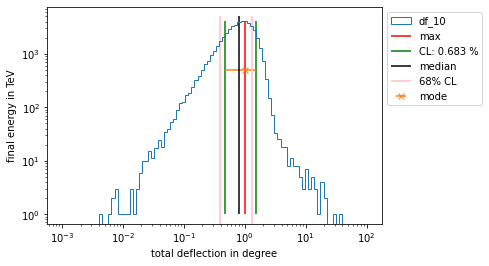

In [36]:
df_key = 'df_10'

bins = np.logspace(-3, 2, 100)

deflection_mode_test = []
deflection_mode_lower_test = []
deflection_mode_upper_test = []
for d in [df_key]:
    df = df_dict[d]
    # si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.3, show=True, plot=True)
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.68, show=True, plot=True)
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode_test.append(si['maximum'])
    deflection_mode_lower_test.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper_test.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode_test, 500, xerr=(deflection_mode_lower_test, deflection_mode_upper_test), fmt='x', label='mode')

plt.vlines(np.median(df_dict[df_key].deflection), 1, 5e3, color='black', label='median')
plt.vlines(np.quantile(df_dict[df_key].deflection, 0.155), 0, 5e3, color='pink', label='68% CL')
plt.vlines(np.quantile(df_dict[df_key].deflection, 0.835), 0, 5e3, color='pink')
print('median: ', np.median(df_dict[df_key].deflection))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.legend(bbox_to_anchor=(1,1))

argmax:  44
number events:  49995
Current CL:  0.9501150115011501
maxixum:  0.00014057303739839087
lower:  2.1544346900318823e-05
upper:  0.0004037017258596554
max =  0.00014057303739839087  -  0.00011902869049807205  +  0.0002631286884612645
median:  0.000119790253776322126616


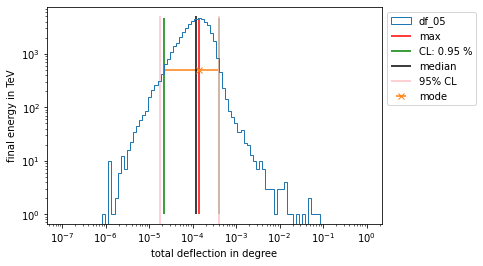

In [49]:
df_key = 'df_05'

bins = np.logspace(-7, 0, 100)

deflection_mode_test = []
deflection_mode_lower_test = []
deflection_mode_upper_test = []
for d in [df_key]:
    df = df_dict[d]
    # si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.3, show=True, plot=True)
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=True, plot=True)
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode_test.append(si['maximum'])
    deflection_mode_lower_test.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper_test.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode_test, 500, xerr=(deflection_mode_lower_test, deflection_mode_upper_test), fmt='x', label='mode')

plt.vlines(np.median(df_dict[df_key].deflection), 1, 5e3, color='black', label='median')
plt.vlines(np.quantile(df_dict[df_key].deflection, 0.025), 0, 5e3, color='pink', label='95% CL')
plt.vlines(np.quantile(df_dict[df_key].deflection, 0.975), 0, 5e3, color='pink')
print('median: ', np.median(df_dict[df_key].deflection))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.legend(bbox_to_anchor=(1,1))

argmax:  44
number events:  50000
Current CL:  0.95328
maxixum:  0.014057303739839086
lower:  0.0015556761439304723
upper:  0.040370172585965536
max =  0.014057303739839086  -  0.012501627595908614  +  0.02631286884612645
median:  0.011436875926425559062


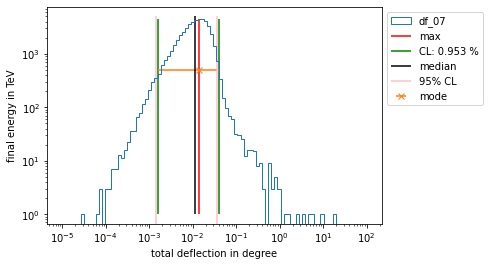

In [50]:
df_key = 'df_07'

bins = np.logspace(-5, 2, 100)

deflection_mode_test = []
deflection_mode_lower_test = []
deflection_mode_upper_test = []
for d in [df_key]:
    df = df_dict[d]
    # si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.3, show=True, plot=True)
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=True, plot=True)
    plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode_test.append(si['maximum'])
    deflection_mode_lower_test.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper_test.append(si['upper_bound'] - si['maximum'])

plt.errorbar(deflection_mode_test, 500, xerr=(deflection_mode_lower_test, deflection_mode_upper_test), fmt='x', label='mode')

plt.vlines(np.median(df_dict[df_key].deflection), 1, 5e3, color='black', label='median')
plt.vlines(np.quantile(df_dict[df_key].deflection, 0.025), 0, 5e3, color='pink', label='95% CL')
plt.vlines(np.quantile(df_dict[df_key].deflection, 0.975), 0, 5e3, color='pink')
print('median: ', np.median(df_dict[df_key].deflection))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('total deflection in degree')
plt.ylabel('final energy in TeV')
plt.legend(bbox_to_anchor=(1,1))

# E_i = 100 TeV

In [40]:
df_dict_unsorted = {}
for i, hdf in enumerate(sorted(os.listdir('data/total_defl_combined_02/'))):
    df = pd.read_hdf('data/total_defl_combined_02/{}'.format(hdf), key='seed_3')
    df_dict_unsorted['df_%02d' %(i+1)] = df

    
E_f_unsorted = [mode(df_dict_unsorted[df].E_f) for df in df_dict_unsorted]

df_dict_100 = {}
for df in [x for _, x in sorted(zip(E_f_unsorted, df_dict_unsorted.keys()))]:
    df_dict_100[df] = df_dict_unsorted[df]
print(df_dict_100.keys())
E_f_100 = sorted(E_f_unsorted)
E_f_100

dict_keys(['df_08', 'df_07', 'df_03', 'df_06', 'df_02', 'df_05', 'df_01', 'df_04'])


[10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0]

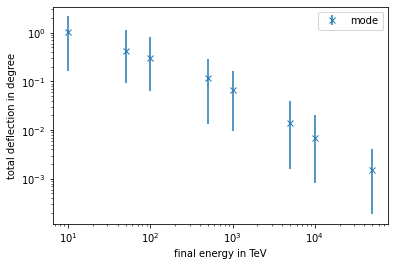

In [41]:
bins = np.logspace(-6, 2, 1000)

deflection_mode_100 = []
deflection_mode_lower_100 = []
deflection_mode_upper_100 = []
for d in df_dict_100: # ['df_00']:
    df = df_dict_100[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode_100.append(si['maximum'])
    deflection_mode_lower_100.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper_100.append(si['upper_bound'] - si['maximum'])

plt.errorbar(E_f_100, deflection_mode_100, yerr=(deflection_mode_lower_100, deflection_mode_upper_100), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('total deflection in degree')
plt.xlabel('final energy in TeV')
plt.legend()

lin params:  [ 0.97487684 -0.77315256] , errors:  [0.13655445 0.04432347]
lin params cut:  [ 1.36249156 -0.87796124] , errors:  [0.14217872 0.04103003]
efit params:  [-1.58346902  0.24032081  2.03834789] , errors:  [0.45532059 0.03938905 0.53313253]


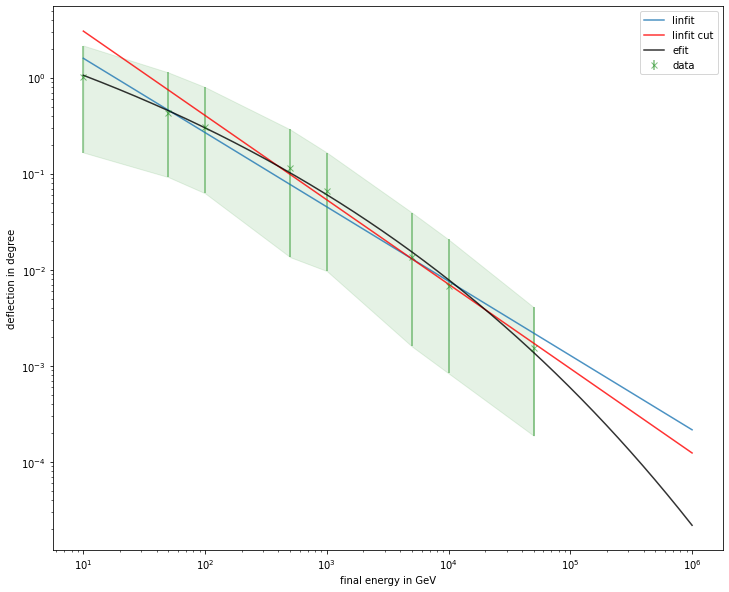

In [42]:
### fit deflection modes 
x = np.logspace(1, 6, 1000)
plt.figure(figsize=(12, 10))

# Power fit
def powerfit(x, a, b):
    return a * np.power(x, b)

params, cov = curve_fit(powerfit, E_f_100, deflection_mode_100, p0=(20, -1))
errors = np.sqrt(np.diag(cov))
# print('power params: ', params, ', errors: ', errors)
# plt.plot(x, powerfit(x, *params), alpha=0.8, label='powerfit')



# Lin fit with all energies
def linlaw(x, a, b) :
    return a + x * b

params, cov = curve_fit(linlaw, np.log10(E_f_100), np.log10(deflection_mode_100)) 
errors = np.sqrt(np.diag(cov))
print('lin params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), alpha=0.8, label='linfit')

# Lin fit without 10 GeV and 50 GeV (too low)
params, cov = curve_fit(linlaw, np.log10(E_f_100[2:]), np.log10(deflection_mode_100[2:])) 
errors = np.sqrt(np.diag(cov))
print('lin params cut: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), color='red', alpha=0.8, label='linfit cut')


# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

params, cov = curve_fit(efit, np.log10(E_f_100), np.log10(deflection_mode_100))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')


plt.errorbar(E_f_100, deflection_mode_100, yerr=(deflection_mode_lower_100, deflection_mode_upper_100), fmt='x', color='green', alpha=0.5, label='data')
plt.fill_between(E_f_100, np.array(deflection_mode_100)-np.array(deflection_mode_lower_100), np.array(deflection_mode_100) + np.array(deflection_mode_upper_100), alpha=0.1, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()

# E_i = 10 TeV

In [43]:
df_dict_unsorted = {}
for i, hdf in enumerate(sorted(os.listdir('data/total_defl_combined_03/'))):
    df = pd.read_hdf('data/total_defl_combined_03/{}'.format(hdf), key='seed_3')
    df_dict_unsorted['df_%02d' %(i+1)] = df

    
E_f_unsorted = [mode(df_dict_unsorted[df].E_f) for df in df_dict_unsorted]

df_dict_10 = {}
for df in [x for _, x in sorted(zip(E_f_unsorted, df_dict_unsorted.keys()))]:
    df_dict_10[df] = df_dict_unsorted[df]
print(df_dict_10.keys())
E_f_10 = sorted(E_f_unsorted)
E_f_10

dict_keys(['df_06', 'df_05', 'df_02', 'df_04', 'df_01', 'df_03'])


[10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]

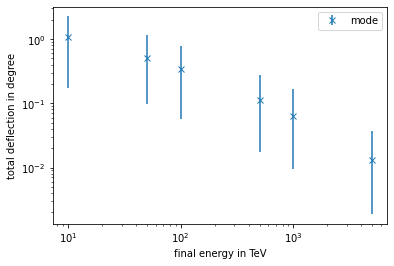

In [44]:
bins = np.logspace(-6, 2, 1000)

deflection_mode_10 = []
deflection_mode_lower_10 = []
deflection_mode_upper_10 = []
for d in df_dict_10: # ['df_00']:
    df = df_dict_10[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode_10.append(si['maximum'])
    deflection_mode_lower_10.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper_10.append(si['upper_bound'] - si['maximum'])

plt.errorbar(E_f_10, deflection_mode_10, yerr=(deflection_mode_lower_10, deflection_mode_upper_10), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('total deflection in degree')
plt.xlabel('final energy in TeV')
plt.legend()

lin params:  [ 0.86162711 -0.7055751 ] , errors:  [0.13663938 0.05440008]
lin params cut:  [ 1.24932672 -0.83398768] , errors:  [0.17585255 0.06034638]
efit params:  [-0.76820871  0.37120054  1.14302093] , errors:  [0.0298485  0.00732867 0.03813448]


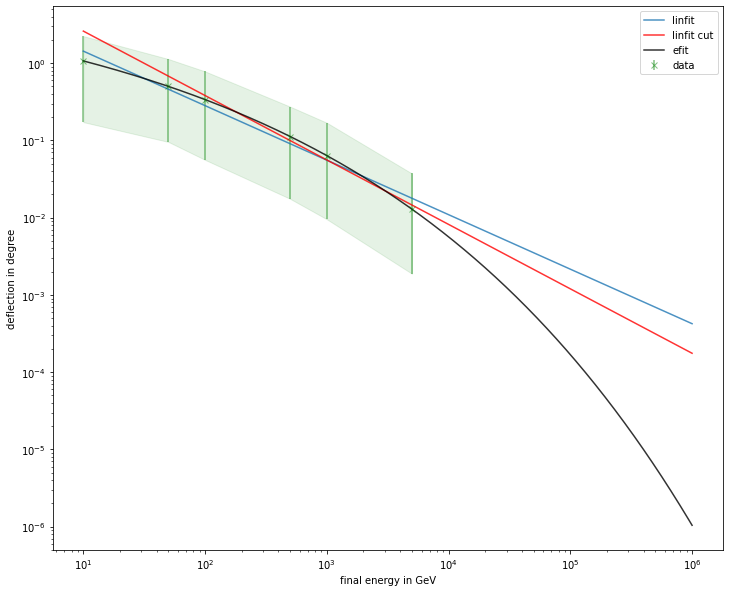

In [45]:
### fit deflection modes 
x = np.logspace(1, 6, 1000)
plt.figure(figsize=(12, 10))

# Power fit
def powerfit(x, a, b):
    return a * np.power(x, b)

params, cov = curve_fit(powerfit, E_f_10, deflection_mode_10, p0=(20, -1))
errors = np.sqrt(np.diag(cov))
# print('power params: ', params, ', errors: ', errors)
# plt.plot(x, powerfit(x, *params), alpha=0.8, label='powerfit')



# Lin fit with all energies
def linlaw(x, a, b) :
    return a + x * b

params, cov = curve_fit(linlaw, np.log10(E_f_10), np.log10(deflection_mode_10)) 
errors = np.sqrt(np.diag(cov))
print('lin params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), alpha=0.8, label='linfit')

# Lin fit without 10 GeV and 50 GeV (too low)
params, cov = curve_fit(linlaw, np.log10(E_f_10[2:]), np.log10(deflection_mode_10[2:])) 
errors = np.sqrt(np.diag(cov))
print('lin params cut: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), color='red', alpha=0.8, label='linfit cut')


# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

params, cov = curve_fit(efit, np.log10(E_f_10), np.log10(deflection_mode_10))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')


plt.errorbar(E_f_10, deflection_mode_10, yerr=(deflection_mode_lower_10, deflection_mode_upper_10), fmt='x', color='green', alpha=0.5, label='data')
plt.fill_between(E_f_10, np.array(deflection_mode_10)-np.array(deflection_mode_lower_10), np.array(deflection_mode_10) + np.array(deflection_mode_upper_10), alpha=0.1, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()

# E_i = 10 PeV

In [46]:
df_dict_unsorted = {}
for i, hdf in enumerate(sorted(os.listdir('data/total_defl_combined_04/'))):
    df = pd.read_hdf('data/total_defl_combined_04/{}'.format(hdf), key='seed_3')
    df_dict_unsorted['df_%02d' %(i+1)] = df

    
E_f_unsorted = [mode(df_dict_unsorted[df].E_f) for df in df_dict_unsorted]

df_dict_10P = {}
for df in [x for _, x in sorted(zip(E_f_unsorted, df_dict_unsorted.keys()))]:
    df_dict_10P[df] = df_dict_unsorted[df]
print(df_dict_10P.keys())
E_f_10P = sorted(E_f_unsorted)
E_f_10P

dict_keys(['df_10', 'df_09', 'df_04', 'df_08', 'df_03', 'df_07', 'df_02', 'df_06', 'df_01', 'df_05', 'df_11', 'df_12'])


[10.0,
 50.0,
 100.0,
 500.0,
 1000.0,
 5000.0,
 10000.0,
 50000.0,
 100000.0,
 500000.0,
 1000000.0,
 5000000.0]

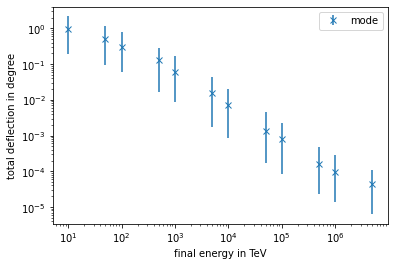

In [47]:
bins = np.logspace(-6, 2, 1000)

deflection_mode_10P = []
deflection_mode_lower_10P = []
deflection_mode_upper_10P = []
for d in df_dict_10P: # ['df_00']:
    df = df_dict_10P[d]
    si = get_smallest_interval_around_mode(df.deflection, bins=bins, CL=0.95, show=False, plot=False)
    # plt.hist(df.deflection, bins=bins, histtype='step', label=d)
    
    deflection_mode_10P.append(si['maximum'])
    deflection_mode_lower_10P.append(si['maximum'] - si['lower_bound'])
    deflection_mode_upper_10P.append(si['upper_bound'] - si['maximum'])

plt.errorbar(E_f_10P, deflection_mode_10P, yerr=(deflection_mode_lower_10P, deflection_mode_upper_10P), fmt='x', label='mode')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('total deflection in degree')
plt.xlabel('final energy in TeV')
plt.legend()

lin params:  [ 1.12139074 -0.83356424] , errors:  [0.11862674 0.02807205]
lin params cut:  [ 1.37102752 -0.88366359] , errors:  [0.12347044 0.02691773]
efit params:  [-11.37474354   0.05836023  12.22636737] , errors:  [9.5754149  0.0398092  9.75697237]
poly params:  [ 0.02931355 -0.36573781  0.51624276 -0.24443561] , errors:  [0.00355397 0.0414242  0.14510812 0.14777467]


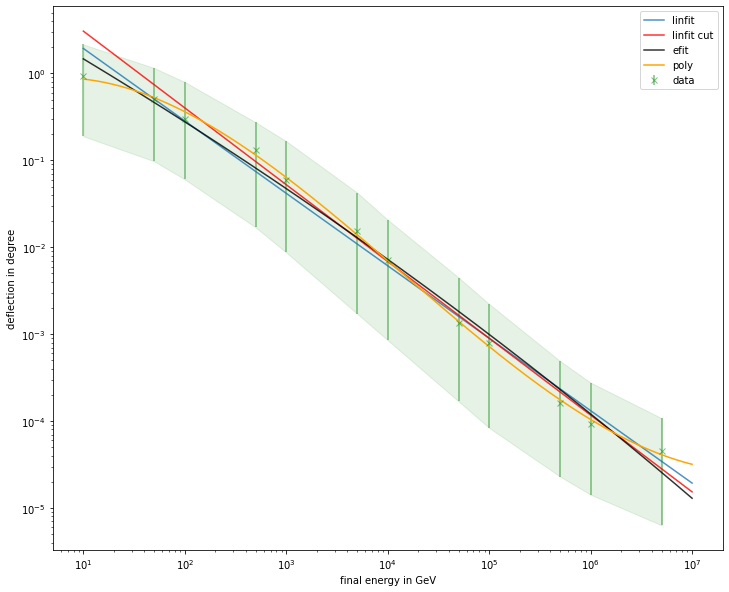

In [48]:
### fit deflection modes 
x = np.logspace(1, 7, 1000)
plt.figure(figsize=(12, 10))

# Power fit
def powerfit(x, a, b):
    return a * np.power(x, b)

params, cov = curve_fit(powerfit, E_f_10P, deflection_mode_10P, p0=(20, -1))
errors = np.sqrt(np.diag(cov))
# print('power params: ', params, ', errors: ', errors)
# plt.plot(x, powerfit(x, *params), alpha=0.8, label='powerfit')



# Lin fit with all energies
def linlaw(x, a, b) :
    return a + x * b

params, cov = curve_fit(linlaw, np.log10(E_f_10P), np.log10(deflection_mode_10P)) 
errors = np.sqrt(np.diag(cov))
print('lin params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), alpha=0.8, label='linfit')

# Lin fit without 10 GeV and 50 GeV (too low)
params, cov = curve_fit(linlaw, np.log10(E_f_10P[2:]), np.log10(deflection_mode_10P[2:])) 
errors = np.sqrt(np.diag(cov))
print('lin params cut: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, linlaw(np.log10(x), *params)), color='red', alpha=0.8, label='linfit cut')


# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

params, cov = curve_fit(efit, np.log10(E_f_10P), np.log10(deflection_mode_10P))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')

# polynom fit
def poly(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

params, cov = curve_fit(poly, np.log10(E_f_10P), np.log10(deflection_mode_10P))
errors = np.sqrt(np.diag(cov))
print('poly params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, poly(np.log10(x), *params)), color='orange', alpha=1, label='poly')

plt.errorbar(E_f_10P, deflection_mode_10P, yerr=(deflection_mode_lower_10P, deflection_mode_upper_10P), fmt='x', color='green', alpha=0.5, label='data')
plt.fill_between(E_f_10P, np.array(deflection_mode_10P)-np.array(deflection_mode_lower_10P), np.array(deflection_mode_10P) + np.array(deflection_mode_upper_10P), alpha=0.1, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()

# Comparison E_i: 10 TeV / 100 Tev / 1 PeV / 10 PeV

efit params:  [-11.37474354   0.05836023  12.22636737] , errors:  [9.5754149  0.0398092  9.75697237]
efit params:  [-2.72885489  0.17183148  3.33401275] , errors:  [1.01269671 0.03910835 1.13466281]
efit params:  [-1.58346902  0.24032081  2.03834789] , errors:  [0.45532059 0.03938905 0.53313253]
efit params:  [-0.76820871  0.37120054  1.14302093] , errors:  [0.0298485  0.00732867 0.03813448]


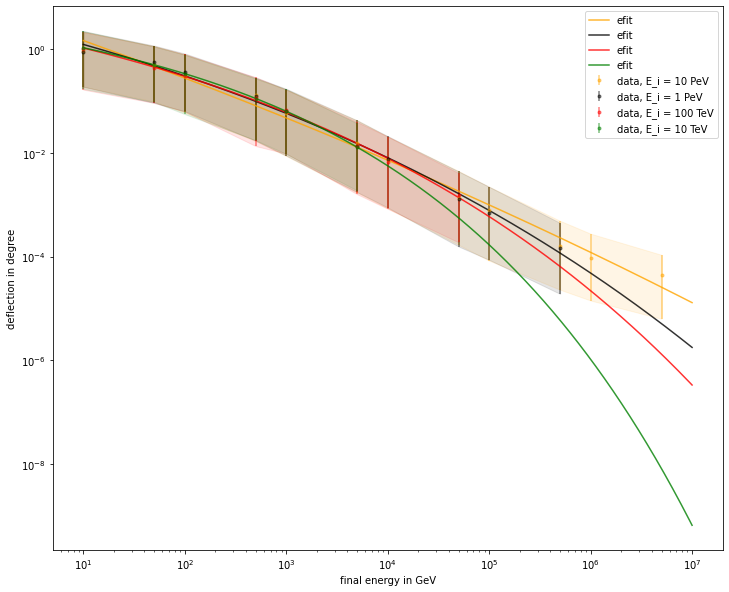

In [21]:
### fit deflection modes 
x = np.logspace(1, 7, 1000)
plt.figure(figsize=(12, 10))

# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

# E_i = 10 PeV
params, cov = curve_fit(efit, np.log10(E_f_10P), np.log10(deflection_mode_10P))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='orange', alpha=0.8, label='efit')

plt.errorbar(E_f_10P, deflection_mode_10P, yerr=(deflection_mode_lower_10P, deflection_mode_upper_10P), fmt='.', color='orange', alpha=0.5, label='data, E_i = 10 PeV')
plt.fill_between(E_f_10P, np.array(deflection_mode_10P)-np.array(deflection_mode_lower_10P), np.array(deflection_mode_10P) + np.array(deflection_mode_upper_10P), alpha=0.1, color='orange')


# E_i = 1 PeV
params, cov = curve_fit(efit, np.log10(E_f), np.log10(deflection_mode))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')

plt.errorbar(E_f, deflection_mode, yerr=(deflection_mode_lower, deflection_mode_upper), fmt='.', color='black', alpha=0.5, label='data, E_i = 1 PeV')
plt.fill_between(E_f, np.array(deflection_mode)-np.array(deflection_mode_lower), np.array(deflection_mode) + np.array(deflection_mode_upper), alpha=0.1, color='black')


# E_i = 100 TeV
params, cov = curve_fit(efit, np.log10(E_f_100), np.log10(deflection_mode_100))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='red', alpha=0.8, label='efit')

plt.errorbar(E_f_100, deflection_mode_100, yerr=(deflection_mode_lower_100, deflection_mode_upper_100), fmt='.', color='red', alpha=0.5, label='data, E_i = 100 TeV')
plt.fill_between(E_f_100, np.array(deflection_mode_100)-np.array(deflection_mode_lower_100), np.array(deflection_mode_100) + np.array(deflection_mode_upper_100), alpha=0.1, color='red')


# E_i = 10 TeV
params, cov = curve_fit(efit, np.log10(E_f_10), np.log10(deflection_mode_10))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='green', alpha=0.8, label='efit')

plt.errorbar(E_f_10, deflection_mode_10, yerr=(deflection_mode_lower_10, deflection_mode_upper_10), fmt='.', color='green', alpha=0.5, label='data, E_i = 10 TeV')
plt.fill_between(E_f_10, np.array(deflection_mode_10)-np.array(deflection_mode_lower_10), np.array(deflection_mode_10) + np.array(deflection_mode_upper_10), alpha=0.1, color='green')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()

# Use median and central intervals

In [70]:
# E_i = 10 PeV
deflection_median_10P = []
deflection_median_lower_10P = [] 
deflection_median_upper_10P = []
for d in df_dict_10P:
    df = df_dict_10P[d]
    deflection_median_10P.append(np.median(df.deflection))
    deflection_median_lower_10P.append(np.median(df.deflection) - np.quantile(df.deflection, 0.025)) # 95% content
    deflection_median_upper_10P.append(np.quantile(df.deflection, 0.975) - np.median(df.deflection))

# E_i = 1 PeV    
deflection_median_1P = []
deflection_median_lower_1P = [] 
deflection_median_upper_1P = []
for d in df_dict:
    df = df_dict[d]
    deflection_median_1P.append(np.median(df.deflection))
    deflection_median_lower_1P.append(np.median(df.deflection) - np.quantile(df.deflection, 0.025)) # 95% content
    deflection_median_upper_1P.append(np.quantile(df.deflection, 0.975) - np.median(df.deflection))
    
# E_i = 100 TabNine::eV
deflection_median_100 = []
deflection_median_lower_100 = [] 
deflection_median_upper_100 = []
for d in df_dict_100:
    df = df_dict_100[d]
    deflection_median_100.append(np.median(df.deflection))
    deflection_median_lower_100.append(np.median(df.deflection) - np.quantile(df.deflection, 0.025)) # 95% content
    deflection_median_upper_100.append(np.quantile(df.deflection, 0.975) - np.median(df.deflection))

# E_i = 10 TeV    
deflection_median_10 = []
deflection_median_lower_10 = [] 
deflection_median_upper_10 = []
for d in df_dict_10:
    df = df_dict_10[d]
    deflection_median_10.append(np.median(df.deflection))
    deflection_median_lower_10.append(np.median(df.deflection) - np.quantile(df.deflection, 0.025)) # 95% content
    deflection_median_upper_10.append(np.quantile(df.deflection, 0.975) - np.median(df.deflection))

poly params:  [ 0.02777554 -0.34624764  0.43784389 -0.24276668] , errors:  [0.00149631 0.01744067 0.06109431 0.06221699]
efit params:  [-12.39891567   0.05466853  13.19148183] , errors:  [ 9.91287103  0.03586415 10.07826995]
efit params:  [-2.94029443  0.16326053  3.46167054] , errors:  [0.79938264 0.02780062 0.88644849]
efit params:  [-1.48056201  0.25113263  1.85143619] , errors:  [0.35758345 0.0338566  0.42425276]
efit params:  [-0.69015106  0.38636558  0.92802098] , errors:  [0.10553685 0.02937519 0.13728822]


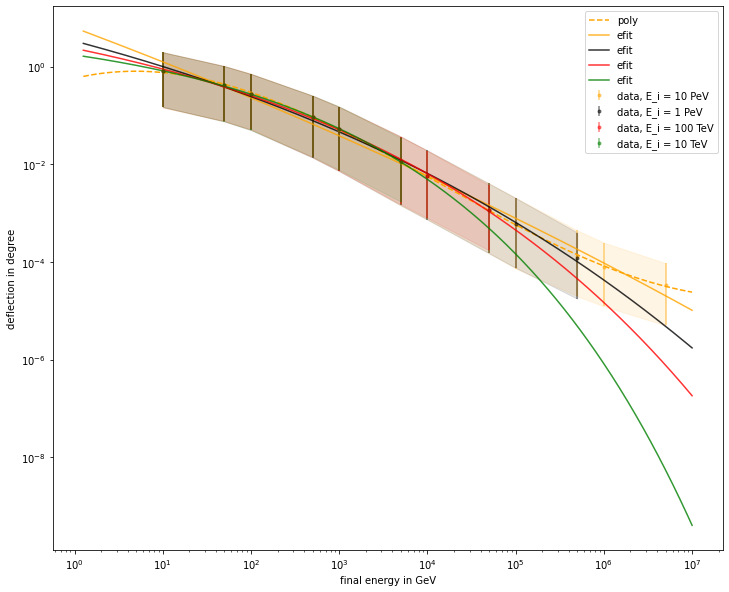

In [75]:
### fit deflection medians
x = np.logspace(0.1, 7, 1000)
plt.figure(figsize=(12, 10))


# polynom fit
def poly(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# E_i = 10 PeV
params, cov = curve_fit(poly, np.log10(E_f_10P), np.log10(deflection_median_10P))
errors = np.sqrt(np.diag(cov))
print('poly params: ', params, ', errors: ', errors)
plt.plot(x, np.power(10, poly(np.log10(x), *params)), '--', color='orange', alpha=1, label='poly')


# e-fit 
def efit(x, a, b, c):
    return a * np.exp(b * x) + c

# E_i = 10 PeV
params, cov = curve_fit(efit, np.log10(E_f_10P), np.log10(deflection_median_10P))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='orange', alpha=0.8, label='efit')

plt.errorbar(E_f_10P, deflection_median_10P, yerr=(deflection_median_lower_10P, deflection_median_upper_10P), fmt='.', color='orange', alpha=0.5, label='data, E_i = 10 PeV')
plt.fill_between(E_f_10P, np.array(deflection_median_10P)-np.array(deflection_median_lower_10P), np.array(deflection_median_10P) + np.array(deflection_median_upper_10P), alpha=0.1, color='orange')


# E_i = 1 PeV
params, cov = curve_fit(efit, np.log10(E_f), np.log10(deflection_median_1P))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='black', alpha=0.8, label='efit')

plt.errorbar(E_f, deflection_median_1P, yerr=(deflection_median_lower_1P, deflection_median_upper_1P), fmt='.', color='black', alpha=0.5, label='data, E_i = 1 PeV')
plt.fill_between(E_f, np.array(deflection_median_1P)-np.array(deflection_median_lower_1P), np.array(deflection_median_1P) + np.array(deflection_median_upper_1P), alpha=0.1, color='black')


# E_i = 100 TeV
params, cov = curve_fit(efit, np.log10(E_f_100), np.log10(deflection_median_100))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='red', alpha=0.8, label='efit')

plt.errorbar(E_f_100, deflection_median_100, yerr=(deflection_median_lower_100, deflection_median_upper_100), fmt='.', color='red', alpha=0.5, label='data, E_i = 100 TeV')
plt.fill_between(E_f_100, np.array(deflection_median_100)-np.array(deflection_median_lower_100), np.array(deflection_median_100) + np.array(deflection_median_upper_100), alpha=0.1, color='red')


# E_i = 10 TeV
params, cov = curve_fit(efit, np.log10(E_f_10), np.log10(deflection_median_10))
errors = np.sqrt(np.diag(cov))
print('efit params: ', params, ', errors: ', errors) 
plt.plot(x, np.power(10, efit(np.log10(x), *params)), color='green', alpha=0.8, label='efit')

plt.errorbar(E_f_10, deflection_median_10, yerr=(deflection_median_lower_10, deflection_median_upper_10), fmt='.', color='green', alpha=0.5, label='data, E_i = 10 TeV')
plt.fill_between(E_f_10, np.array(deflection_median_10)-np.array(deflection_median_lower_10), np.array(deflection_median_10) + np.array(deflection_median_upper_10), alpha=0.1, color='green')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('final energy in GeV')
plt.ylabel('deflection in degree')
plt.legend()